In [23]:
## load packages
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [24]:
chap_3_file = "./data/pbp_py_chap_3.csv"
## load data
if os.path.isfile(chap_3_file):
    pbp_py = pd.read_csv(chap_3_file, low_memory=False)
else:
    seasons = range(2016, 2022 + 1)
    pbp_py = nfl.import_pbp_data(seasons)
    pbp_py.to_csv(chap_3_file)

In [25]:
## filter run data and replace missing values
pbp_py_run = pbp_py.query('play_type == "run" & rusher_id.notnull()').reset_index()
pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

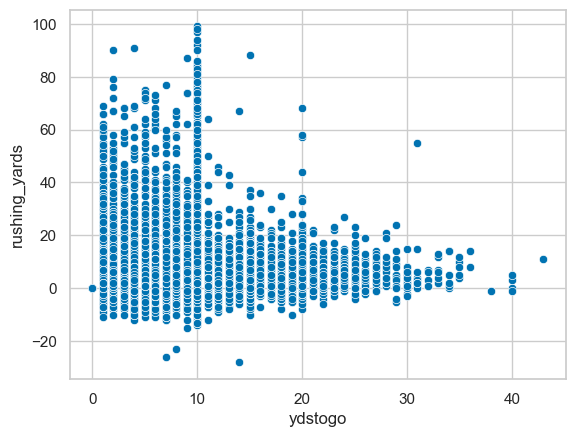

In [26]:

## plot raw data prior to building model
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards")
plt.show()

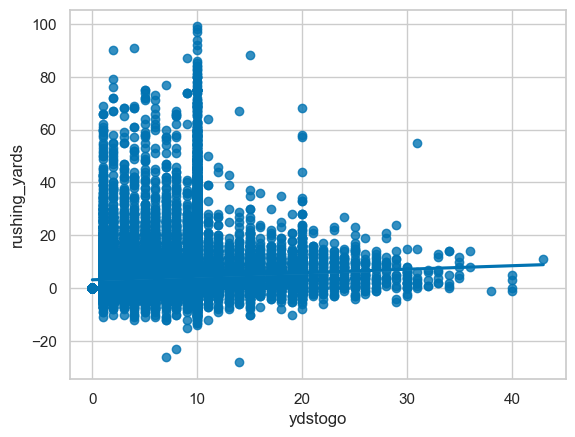

In [27]:
## add linear trend line
sns.regplot(data=pbp_py_run, x="ydstogo", y="rushing_yards")
plt.show()

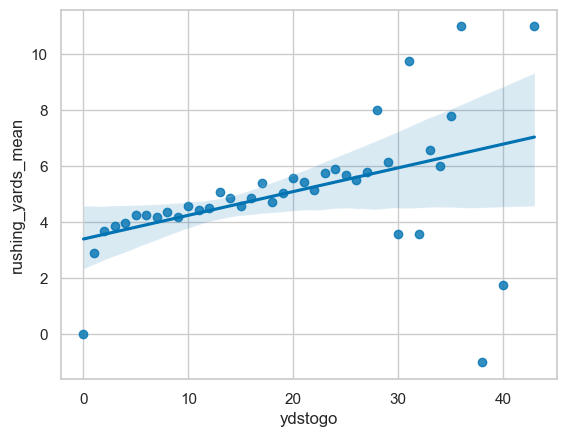

In [28]:
## bin and plot data
pbp_py_run_ave = pbp_py_run.groupby(["ydstogo"]).agg({"rushing_yards": ["mean"]})
pbp_py_run_ave.columns = list(map("_".join, pbp_py_run_ave.columns))
pbp_py_run_ave.reset_index(inplace=True)
sns.regplot(data=pbp_py_run_ave, x="ydstogo", y="rushing_yards_mean")
plt.show()


In [29]:
## build and fit linear regression
yard_to_go_py = smf.ols(formula="rushing_yards ~ 1 + ydstogo", data=pbp_py_run)
print(yard_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     623.7
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          3.34e-137
Time:                        00:17:45   Log-Likelihood:            -3.0107e+05
No. Observations:               92425   AIC:                         6.021e+05
Df Residuals:                   92423   BIC:                         6.022e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2188      0.047     68.142      0.0

In [30]:
## save residuals as RYOE
pbp_py_run["ryoe"] = yard_to_go_py.fit().resid

In [31]:
## query, format, and print RYOE results
ryoe_py = pbp_py_run.groupby(["season", "rusher_id", "rusher"]).agg(
    {"ryoe": ["count", "sum", "mean"], "rushing_yards": "mean"}
)

In [32]:
ryoe_py.columns = list(map("_".join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

In [33]:
ryoe_py = ryoe_py.rename(
    columns={
        "ryoe_count": "n",
        "ryoe_sum": "ryoe_total",
        "ryoe_mean": "ryoe_per",
        "rushing_yards_mean": "yards_per_carry",
    }
).query("n > 50")

In [34]:
print(ryoe_py.sort_values("ryoe_total", ascending=False))

      season   rusher_id     rusher    n  ryoe_total  ryoe_per  \
1989    2021  00-0036223   J.Taylor  332  417.501295  1.257534   
1440    2020  00-0032764    D.Henry  397  362.768406  0.913774   
1258    2019  00-0034796  L.Jackson  135  353.652105  2.619645   
1143    2019  00-0032764    D.Henry  387  323.921354  0.837006   
1474    2020  00-0033293    A.Jones  222  288.358241  1.298911   
...      ...         ...        ...  ...         ...       ...   
419     2017  00-0029613   D.Martin  139 -198.461432 -1.427780   
122     2016  00-0029613   D.Martin  144 -199.156646 -1.383032   
675     2018  00-0027325   L.Blount  155 -247.528360 -1.596957   
1058    2019  00-0030496     L.Bell  245 -286.996618 -1.171415   
267     2016  00-0032241   T.Gurley  278 -319.803875 -1.150374   

      yards_per_carry  
1989         5.454819  
1440         5.206549  
1258         6.800000  
1143         5.131783  
1474         5.540541  
...               ...  
419          2.920863  
122          2.

In [35]:
## RYOE stability
#  keep only columns needed
cols_keep = ["season", "rusher_id", "rusher", "ryoe_per", "yards_per_carry"]

In [36]:
# create current dataframe
ryoe_now_py = ryoe_py[cols_keep].copy()

In [37]:
# create last-year's dataframe
ryoe_last_py = ryoe_py[cols_keep].copy()

In [38]:
# rename columns
ryoe_last_py.rename(
    columns={"ryoe_per": "ryoe_per_last", "yards_per_carry": "yards_per_carry_last"},
    inplace=True,
)

In [39]:
# add 1 to season
ryoe_last_py["season"] += 1

In [40]:
# merge together
ryoe_lag_py = ryoe_now_py.merge(
    ryoe_last_py, how="inner", on=["rusher_id", "rusher", "season"]
)

In [41]:
## Look at correlation
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.00000,0.32261
yards_per_carry,0.32261,1.00000


In [42]:
## repeat with RYOE
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.348923
ryoe_per,0.348923,1.000000
